# Spark, RDD setup and Kmeans

In [1]:
from pyspark.mllib.clustering import KMeans, KMeansModel
from numpy import array
from math import sqrt
from pyspark import SparkContext, SparkConf
from pyspark.sql.session import SparkSession # Don't mix this up with SparkConf()

In [2]:
conf = SparkConf()\
    .setMaster("local")\
    .setAppName("test")\
    .set("spark.network.timeout", "600s")\
    .setExecutorEnv('spark.executor.memory', '56g')\
    .setExecutorEnv('spark.executor.cores', '32')\
    .setExecutorEnv('spark.cores.max', '32')

# Changing ExecutorEnv is important to maximise the potential of your server instance

In [3]:
sc = SparkContext(conf=conf)

In [4]:
data = sc.textFile('/home/ubuntu/combined2.csv', 100) # Creates an RDD with 100 partitions

In [5]:
parsedData1 = data.map(lambda line: array([x for x in line.split(',')])[1:])

In [6]:
parsedData1.take(1)

[array(['-0.288613958463205', '-0.307302491033818', '-0.29450582616147',
        ..., '-0.279129886834848', '-0.260242594669865',
        '-0.146590774656207'], dtype='<U23')]

In [8]:
model = KMeans.train(parsedData1, 20, maxIterations=10, initializationMode= "k-means||", seed=2)
predictions = model.predict(parsedData1)

In [9]:
predictions.take(10)

[3, 18, 3, 3, 3, 1, 1, 1, 0, 1]

In [10]:
pred_count = predictions.countByValue()

In [11]:
print(pred_count)

defaultdict(<class 'int'>, {0: 6856, 9: 1416, 4: 693, 7: 236, 1: 705, 2: 124, 5: 256, 8: 48, 6: 66, 3: 112})


In [12]:
cluster_list = predictions.collect()

# PCA

In [13]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix

In [14]:
mat = RowMatrix(parsedData1)

In [15]:
pc = mat.computePrincipalComponents(50)

In [16]:
projected = mat.multiply(pc)

In [17]:
pcaFeatures = projected.rows.collect()

# TSNE and Visualisation

In [18]:
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import cm

In [19]:
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
embedded = tsne.fit_transform(pcaFeatures)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 41609 samples in 0.219s...
[t-SNE] Computed neighbors for 41609 samples in 103.208s...
[t-SNE] Computed conditional probabilities for sample 1000 / 41609
[t-SNE] Computed conditional probabilities for sample 2000 / 41609
[t-SNE] Computed conditional probabilities for sample 3000 / 41609
[t-SNE] Computed conditional probabilities for sample 4000 / 41609
[t-SNE] Computed conditional probabilities for sample 5000 / 41609
[t-SNE] Computed conditional probabilities for sample 6000 / 41609
[t-SNE] Computed conditional probabilities for sample 7000 / 41609
[t-SNE] Computed conditional probabilities for sample 8000 / 41609
[t-SNE] Computed conditional probabilities for sample 9000 / 41609
[t-SNE] Computed conditional probabilities for sample 10000 / 41609
[t-SNE] Computed conditional probabilities for sample 11000 / 41609
[t-SNE] Computed conditional probabilities for sample 12000 / 41609
[t-SNE] Computed conditional probabilities for 

In [20]:
# Color for the original tissue types
annotations = sc.textFile('/home/ubuntu/annotations_FACS.csv', 100) 
annotations = annotations.map(lambda line: list([x for x in line.split(',')]))

In [34]:
annotation_list = annotations.collect()
annotation_dict = {}
ontology_dict = {}
unique_ontology_classes = []
unique_tissues = []
for lst in annotation_list:
    annotation_dict[lst[0]] = lst[1]
    ontology_dict[lst[0]] = lst[2]
    if lst[1] not in unique_tissues:
        unique_tissues.append(lst[1])
    if lst[2] not in unique_ontology_classes:
        unique_ontology_classes.append(lst[2])

In [35]:
cell_ids = data.map(lambda line: list([x for x in line.split(',')])[0]).collect()

In [56]:
assigned = []
assigned2 = []
for i in range(len(cell_ids)):
    c = cell_ids[i]
    if c not in annotation_dict.keys():
        assigned.append(0)
    else:
        t = ontology_dict[c]
        assigned.append(unique_ontology_classes.index(t)+1)
        t2 = annotation_dict[c]
        assigned2.append(unique_tissues.index(t2)+1)

In [62]:
from collections import Counter
ind = {}
ind2 = {}
for a in Counter(assigned).keys():
    ind[a] = [i for i,val in enumerate(assigned) if val==a]
for a in Counter(assigned2).keys():
    ind2[a] = [i for i,val in enumerate(assigned2) if val==a]

In [59]:
import math

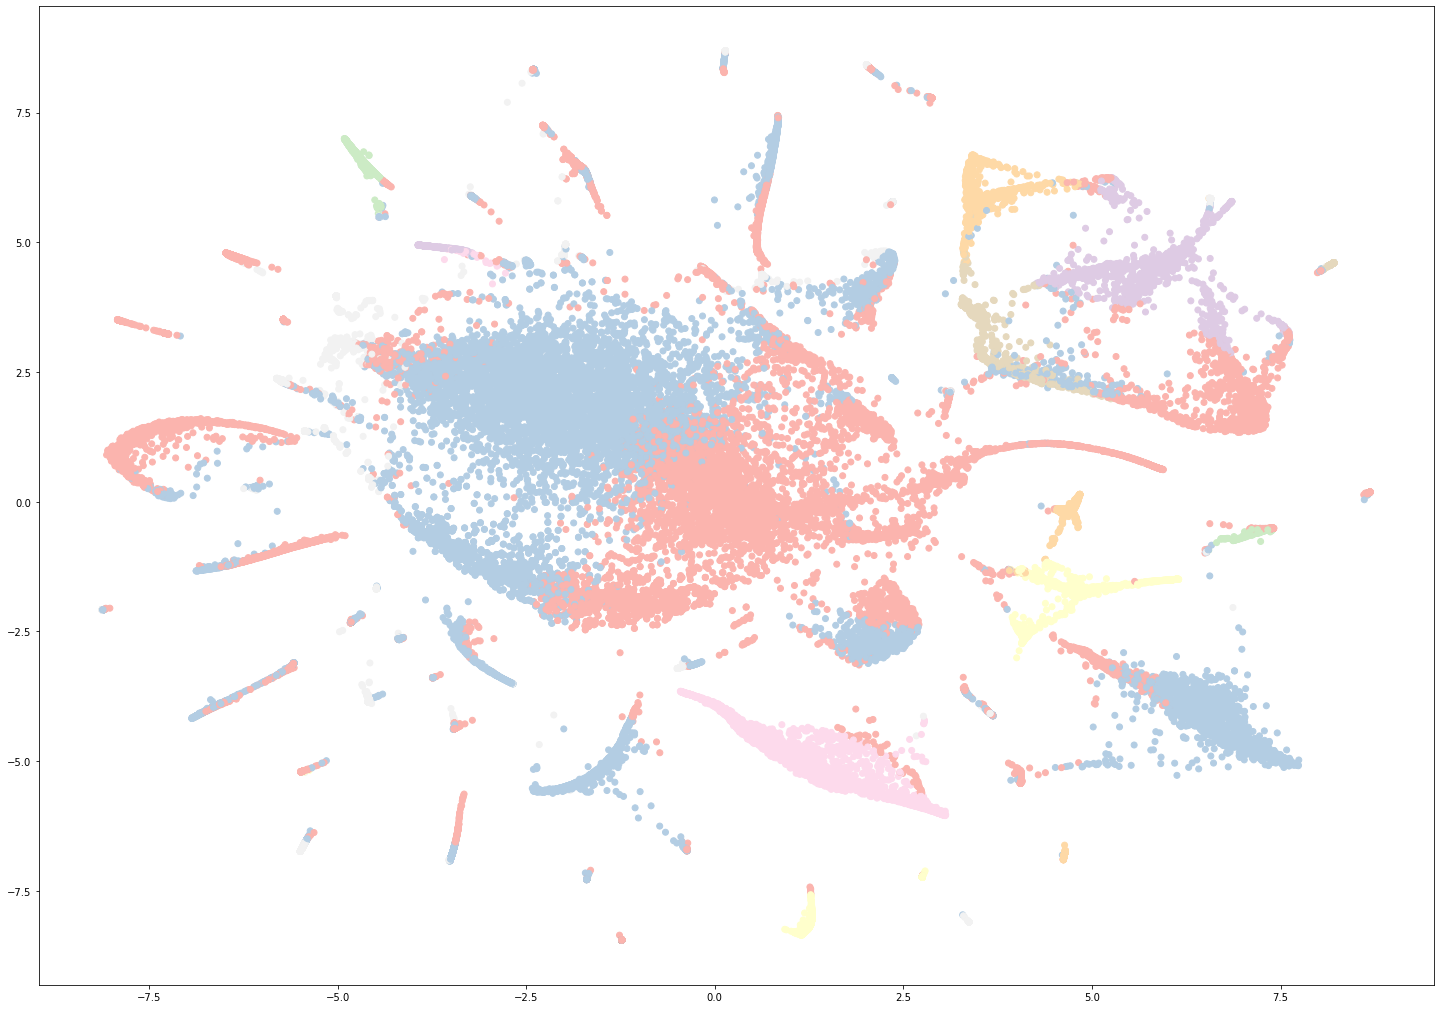

In [77]:
plt.figure(figsize=(25,18))
plt.rcParams['axes.facecolor']='white'
x, y = zip(*embedded)
ax1 = plt.subplot(1,1, 1)
ax1.scatter(x, y, c=cluster_list, cmap = "Pastel1")
color_set = ["black", "lightgrey", "lightcoral", "red", "bisque", "orange", "gold", "olive", "greenyellow", "forestgreen","turquoise", "paleturquoise", "deepskyblue", "dodgerblue", "royalblue", "blueviolet", "indigo","darkmagenta", "fuchsia", "deeppink", "lightpink","maroon","peru","darkcyan","mintcream","crimson"]
colors = {}

for i in range(len(unique_ontology_classes)):
    colors[i] = color_set[max(i%len(color_set),1)]
    
    
# ax3 = plt.subplot(1, 1, 1)
# for i in ind.keys():
#     j = ind[i]
#     if i == 0:
#         lab = "Unknown"
#         col = "black"
#     else:
#         lab = unique_ontology_classes[i-1]
#         col = colors[i-1]
#     ax3.scatter([x[a] for a in j] , [y[a] for a in j], c=col, label = lab)
# ax3.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')


# ax2 = plt.subplot(1,1, 1)
# for i in ind2.keys():
#     j = ind2[i]
#     if i == 0:
#         lab = "Unknown"
#         col = "black"
#     else:
#         lab = unique_tissues[i-1]
#         col = colors[i-1]
#     ax2.scatter([x[a] for a in j] , [y[a] for a in j], c=col, label = lab)
# ax2.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')


plt.show()